In [1]:
import copy
import pickle
import random
from collections import defaultdict, namedtuple, Counter
from itertools import combinations, permutations
import os

import numpy as np
import scipy.stats

import pandas as pd
import networkx as nx
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline

# Loading starting data

In [2]:
model_data = pd.read_csv("ColdWarActors_1948.csv")
model_data.head()

,Unnamed: 0,Capability,Country,Position
0,0,0.294660,United States of America,1.000000e+00
1,1,0.164000,Russia,-3.439353e-16
2,2,0.115055,China,5.724034e-01
3,3,0.075426,United Kingdom,5.368582e-01
4,4,0.052450,India,5.632982e-01


# Unserialize run data

In [3]:
class Model_Output:
    def __init__(self, model):
        '''
        Store data from model run.
        '''
        self.agent_vars = model.datacollector.get_agent_vars_dataframe()
        self.model_vars = model.datacollector.get_model_vars_dataframe()
        self.log = model.log

In [4]:
model_runs = []
filename = "data_output/ColdWar_Experiment3_1.pickle"
with open(filename, "rb") as f:
    model_runs += pickle.load(f)

# Get agent positions

In [5]:
all_dfs = []
for i, model in enumerate(model_runs):
    df = model.agent_vars.copy()
    df.reset_index(inplace=True)
    df["Iteration"] = i
    all_dfs.append(df)
agent_positions = pd.concat(all_dfs)

In [6]:
agent_positions.tail()

,Step,AgentID,Position,Iteration
1795,24,United States of America,0.982022,999
1796,24,Uruguay,0.974070,999
1797,24,Venezuela,0.906321,999
1798,24,Yemen Arab Republic,0.578550,999
1799,24,Yugoslavia,0.325946,999


## How far do agents end up from their starting positions?

In [7]:
end_positions = agent_positions[agent_positions.Step==24]\
    .groupby("AgentID")["Position"].aggregate([np.mean, np.std])

end_positions = end_positions.rename(columns={"mean": "EndPos_mean",
                             "std": "EndPos_std"})

end_positions = end_positions.merge(model_data, left_index=True, right_on="Country")
end_positions["Delta"] = end_positions.EndPos_mean - end_positions.Position

In [8]:
end_positions.head()

,EndPos_mean,EndPos_std,Unnamed: 0,Capability,Country,Position,Delta
34,0.582343,0.003485,34,0.002334,Afghanistan,0.581933,0.000411
53,0.357931,0.013059,53,0.000861,Albania,0.355385,0.002546
17,0.950969,0.025071,17,0.008271,Argentina,0.980751,-0.029782
15,0.571636,0.001521,15,0.008334,Australia,0.572403,-0.000767
14,0.432078,0.008895,14,0.010908,Belgium,0.422577,0.009501


-0.00533464418507
-0.0341392833484
0.110946544535


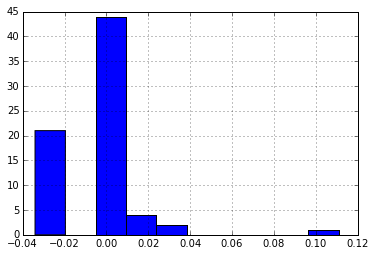

In [9]:
print(end_positions.Delta.mean())
print(end_positions.Delta.min())
print(end_positions.Delta.max())
end_positions.Delta.hist()

## Dyadic distance

In [10]:
agent_positions.tail()

,Step,AgentID,Position,Iteration
1795,24,United States of America,0.982022,999
1796,24,Uruguay,0.974070,999
1797,24,Venezuela,0.906321,999
1798,24,Yemen Arab Republic,0.578550,999
1799,24,Yugoslavia,0.325946,999


In [11]:
STEP = 24

In [12]:
distances = defaultdict(lambda: defaultdict(list))
for i, group in agent_positions.groupby("Iteration"):
    group = group[group.Step==STEP]
    for i, r1 in group.iterrows():
        source_name = r1.AgentID
        source_pos = r1.Position
        for j, r2 in group.iterrows():
            target_name = r2.AgentID
            target_pos = r2.Position
            if target_name == source_name:
                continue
            distances[source_name][target_name].append(abs(source_pos - target_pos))

In [13]:
distances = {key: dict(val) for key, val in distances.items()}

In [14]:
mean_distances = {}
for source, targets in distances.items():
    for target, dist_list in targets.items():
        mean_dist = np.mean(dist_list)
        mean_distances[(source, target)] = mean_dist

In [15]:
mean_distances = pd.DataFrame({"Mean_Distance": mean_distances})
mean_distances.reset_index(inplace=True)

In [16]:
mean_distances.rename(columns={"level_0": "Source", "level_1": "Target"}, inplace=True)

In [17]:
mean_distances.head()

,Source,Target,Mean_Distance
0,Afghanistan,Albania,0.224412
1,Afghanistan,Argentina,0.368625
2,Afghanistan,Australia,0.010721
3,Afghanistan,Belgium,0.150265
4,Afghanistan,Bolivia,0.367467


# Getting alliance network

In [18]:
COW = "/Users/dmasad/Data/COW/"
YEAR = 1998
alliance_dyads = pd.read_csv(COW + "Alliances/alliance_v4.1_by_dyad_yearly.csv")
alliance_dyads = alliance_dyads[alliance_dyads.year==YEAR]
alliance_dyads["Alliance"] = 0
alliance_dyads.loc[(alliance_dyads.entente==1),"Alliance"] = 1
alliance_dyads.loc[(alliance_dyads.nonaggression==1),"Alliance"] = 2
alliance_dyads.loc[(alliance_dyads.neutrality==1),"Alliance"] = 3
alliance_dyads.loc[(alliance_dyads.defense==1),"Alliance"] = 4

In [19]:
alliance_dyads.head()

,version4id,ccode1,state_name1,ccode2,state_name2,dyad_st_day,dyad_st_month,dyad_st_year,dyad_end_day,dyad_end_month,dyad_end_year,left_censor,right_censor,defense,neutrality,nonaggression,entente,year,version,Alliance
182,1,200,United Kingdom,235,Portugal,1,1,1816,NaN,NaN,2012,1,1,1,0,1,0,1998,4.1,4
3712,88,130,Ecuador,145,Bolivia,17,4,1911,NaN,NaN,2012,0,1,0,1,1,0,1998,4.1,3
7460,170,145,Bolivia,150,Paraguay,21,7,1938,NaN,NaN,2012,0,1,0,0,1,0,1998,4.1,2
7638,185,100,Colombia,101,Venezuela,17,12,1939,NaN,NaN,2012,0,1,0,0,1,0,1998,4.1,2
8343,199,435,Mauritania,520,Somalia,22,1,1974,NaN,NaN,2012,0,1,0,0,1,1,1998,4.1,2


In [20]:
state_names = set(alliance_dyads.state_name1.unique())\
        .union(set(alliance_dyads.state_name2.unique()))

In [21]:
for name in mean_distances.Source.unique():
    if name not in state_names:
        print(name)

Afghanistan
Cuba
Czechoslovakia
Iran
Ireland
Mongolia
Myanmar
Nepal
New Zealand
Sri Lanka
Sweden
Switzerland
Thailand
Yemen Arab Republic


In [22]:
mean_distances.replace(["England", "USSR", "USA"], 
                       ["United Kingdom", "Russia", "United States of America"], inplace=True)

In [23]:
alliance_dyads = alliance_dyads[["state_name1", "state_name2", "Alliance"]]

In [24]:
alliances = alliance_dyads.set_index(["state_name1", "state_name2"]).Alliance

In [25]:
alliance_types = {}
for state_1, state_2 in permutations(state_names, 2):
    if (state_2, state_1) in alliance_types:
        continue
    elif (state_2, state_1) in alliances:
        continue
    elif (state_1, state_2) in alliances:
        if type(alliances[(state_1, state_2)]) is pd.Series:
            alliance_types[(state_1, state_2)] = alliances[(state_1, state_2)].max()
        else:
            alliance_types[(state_1, state_2)] = alliances[(state_1, state_2)]
    else:
        alliance_types[(state_1, state_2)] = 0 

/Users/dmasad/.virtualenvs/consul/lib/python3.4/site-packages/pandas/core/index.py:5091: PerformanceWarning: indexing past lexsort depth may impact performance.
  PerformanceWarning)


In [26]:
all_alliances = pd.DataFrame({"Alliance": alliance_types})

In [27]:
all_alliances.reset_index(inplace=True)
all_alliances.rename(columns={"level_0": "Source", "level_1": "Target"}, inplace=True)

In [28]:
merged_data = all_alliances.merge(mean_distances, on=["Source", "Target"])

In [29]:
merged_data.Mean_Distance = abs(merged_data.Mean_Distance)

In [30]:
merged_data.head()

,Source,Target,Alliance,Mean_Distance
0,Albania,Argentina,0,0.593038
1,Albania,Australia,0,0.213705
2,Albania,Belgium,0,0.074147
3,Albania,Bolivia,0,0.591879
4,Albania,Brazil,0,0.595161


In [31]:
merged_data.corr()

,Alliance,Mean_Distance
Alliance,1.000000,-0.428596
Mean_Distance,-0.428596,1.000000


In [32]:
merged_data.to_csv("transfer/ex3_data.csv")

In [33]:
merged_data["Const."] = 1

In [34]:
mn = sm.MNLogit(merged_data.Alliance, merged_data[["Const.", "Mean_Distance"]]).fit()
print(mn.summary())

Optimization terminated successfully.
         Current function value: 0.454121
         Iterations 10
                          MNLogit Regression Results                          
Dep. Variable:               Alliance   No. Observations:                 1653
Model:                        MNLogit   Df Residuals:                     1645
Method:                           MLE   Df Model:                            4
Date:                Tue, 08 Dec 2015   Pseudo R-squ.:                  0.2011
Time:                        13:11:45   Log-Likelihood:                -750.66
converged:                       True   LL-Null:                       -939.67
                                        LLR p-value:                 1.565e-80
   Alliance=1       coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Const.           -7.3869      1.601     -4.614      0.000       -10.525    -4.249
Mean_Distance     2

In [35]:
with open("transfer/mn3_out.csv", "w") as f:
    csv_out = mn.summary().tables[1].as_csv() 
    f.write(csv_out)

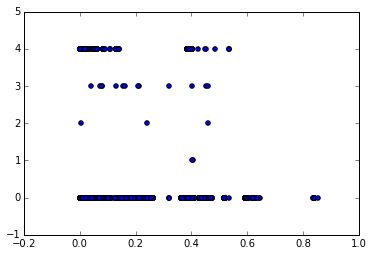

In [36]:
plt.scatter(merged_data.Mean_Distance, merged_data.Alliance)

# Export to R for ERGM

In [37]:
# Only needs to be run once for Experiments 1-2 and 3-4
adj_mat = merged_data.pivot("Source", "Target", "Alliance").fillna(0)
adj_mat.replace([1, 2, 3], [0, 0, 0], inplace=True)
adj_mat.replace(4, 1, inplace=True)
adj_mat.to_csv("transfer/alliance_adj_mat_2.csv")

In [38]:
dist = merged_data.pivot("Source", "Target", "Mean_Distance").fillna(0)
dist.to_csv("transfer/ex3_dist.csv")